In [15]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt

# 1. Exploratory data analysis

In [16]:
data = pd.read_csv('/datasets/faces/labels.csv')

print(data.info())
print(data.head(5))

print('\nsize of dataset:',data.shape[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

size of dataset: 7591


Looks like there are no null rows in our dataframe. We can immediately analyze our dataset.

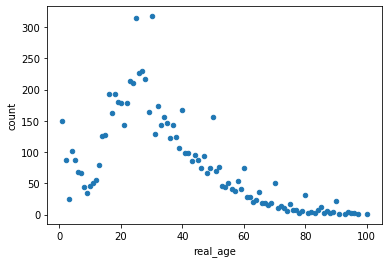

In [20]:
distribution = data['real_age'].value_counts().reset_index()
distribution.columns = ['real_age', 'count']
distribution.plot(kind='scatter', x='real_age', y='count')

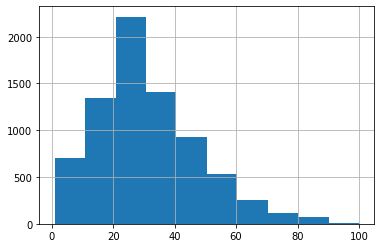

In [21]:
data['real_age'].hist()

In [22]:
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255)

path = '/datasets/faces/final_files/'

generator = datagen.flow_from_dataframe(data, path,
                                               x_col = 'file_name', y_col = 'real_age', 
                                               class_mode = 'raw', batch_size = 16,
                                                  target_size=(150, 150), seed=12345) 

In [23]:
for i in range(10):
    print(next(generator))

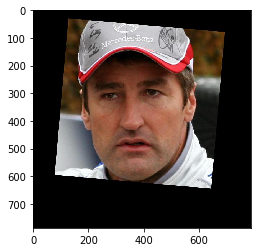

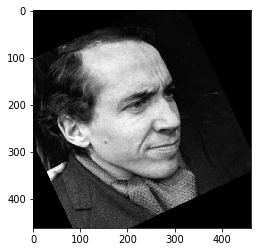

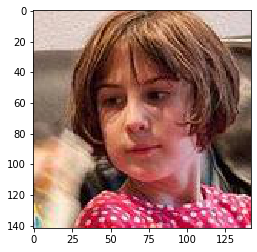

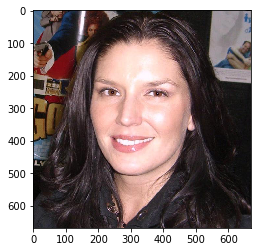

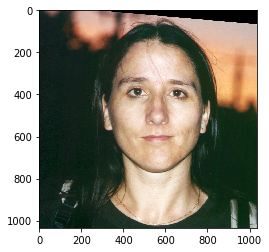

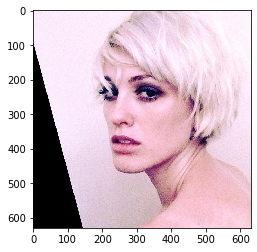

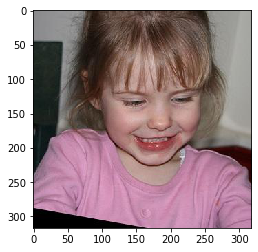

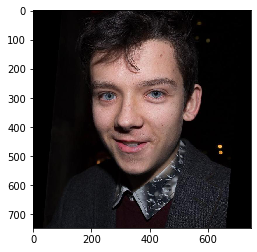

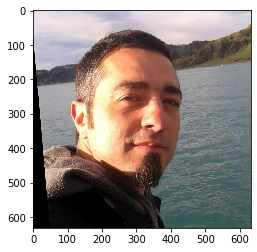

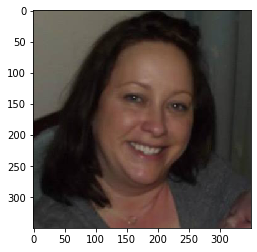

In [24]:
image_list = []
for filename in glob.glob('/datasets/faces/final_files/*.jpg'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)
    if len(image_list)==10:
        break

for i in image_list[0:10]:
    array = np.array(i)
    plt.figure()
    plt.imshow(array)

The scatter plot shows that our dataset consists of primarily people between the age of 0-60. After that mark, it significantly decreases, showing a right skew in our dataset. This may negatively affect our model training, given the fact that there is less images of older people to train our model. Our model may have more difficulties determining the age of customers that are on the older side. Printing our data shows three-dimensional arrays, meaning that we're working with color images. This can be seen in the sample pictures following. There is much diversity in gender and age within our dataset, but in our case we're creating a model to simply determine age. Based on what we know, we'll determine how to build our model.

1. Knowing that we're training a dataset with images, we'll use **ReLU** as our activation function. This will allow add more layers to our model to process the images.
2. We'll need to train our model more efficiently since we're working with images. We'll use the **adam algorithm** to do so, and set the learning rate lower to improve the overall quality of the model.
3. Since we're working with more than 7000 images, we'll use **ImageDataGenerator** from the Keras library to implement dynamic data loading. RAM resources are limited!
4. Our data is skewed, so we'll use **augmentation** to artificially expand our dataset.
5. We can use **ResNet architecture** to improve our model even further, and train our model on **imagenet** first before adding the next layers to gain a better result.


# 2. Model training

Transfer the model training code and the result of printing on the screen here.


(The code in this section is run on a separate GPU platform, so it is not designed as a cell with a code, but as a code in a text cell)

```

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import numpy as np
from tensorflow.keras.optimizers import Adam

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=directory,
                                                            x_col = 'file_name', 
                                                            y_col = 'real_age', 
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            subset='training',
                                                            seed=12345)
    
    return train_datagen_flow
    
def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=directory,
                                                            x_col = 'file_name', 
                                                            y_col = 'real_age',
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            subset='validation',
                                                            seed=12345)
 
    return test_datagen_flow
    
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    optimizer = Adam(lr=0.00005) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=4, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    
    return model
```

```

Train for 356 steps, validate for 119 steps
Epoch 1/4
2020-12-23 23:37:39.724824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-23 23:37:44.150873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 137s - loss: 253.3016 - mae: 11.5155 - val_loss: 920.4014 - val_mae: 25.5725
Epoch 2/4
356/356 - 40s - loss: 80.2371 - mae: 6.7344 - val_loss: 149.0682 - val_mae: 9.1021
Epoch 3/4
356/356 - 41s - loss: 54.9011 - mae: 5.6803 - val_loss: 71.5432 - val_mae: 6.3347
Epoch 4/4
356/356 - 41s - loss: 41.3202 - mae: 4.8817 - val_loss: 78.9027 - val_mae: 6.6549

```

# 3. Trained model analysis

The value for our validation set's loss function is slightly higher than the training set's loss function, which reveals slight overfitting. Our goal is to get a MAE value below 7, and we have accomplished that with 4 epochs. Our model can be used to determine a person's age by a photo now. This can be utilized for several purposes such as collecting data on customers to identify similar purchases habits between customers of the same age, using that data to target advertisements to certain age groups, and determining the age of a customer at a checkout counter to automate the approval or disapproval of a sale of alcohol.